##1. Conexão ao Banco de Dados SQL Server (AdventureWorks)
####Consulta utilizada para extração dos dados
```
SELECT
    CAST(A.OrderDate AS DATE) AS "DT_PEDIDO",
    A.TotalDue AS "NO_VALOR_TOTAL",
    C.Name AS "DS_REGIAO",
    E.Name AS "DS_PRODUTO"
FROM SALES.SalesOrderHeader A

-- Associação com a tabela de endereços para obter o identificador da província de destino
LEFT JOIN Person.Address B
    ON A.ShipToAddressID = B.AddressID

-- Associação com a tabela de províncias para recuperar o nome da região
LEFT JOIN Person.StateProvince C
    ON B.StateProvinceID = C.StateProvinceID

-- Associação com os detalhes do pedido para obter os produtos relacionados à venda
LEFT JOIN SALES.SalesOrderDetail D
    ON A.SalesOrderID = D.SalesOrderID

-- Associação com a tabela de produtos para recuperar o nome do item vendido
LEFT JOIN Production.Product E
    ON D.ProductID = E.ProductID
```



##2. Manipulação e Análise de Dados com Python

###Importando os dados

In [1]:
import pandas as pd
dataset = pd.read_excel('dataset.xlsx', index_col=None)

#Analisando os tipos de dados
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121317 entries, 0 to 121316
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   DT_PEDIDO       121317 non-null  datetime64[ns]
 1   NO_VALOR_TOTAL  121317 non-null  float64       
 2   DS_REGIAO       121317 non-null  object        
 3   DS_PRODUTO      121317 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 3.7+ MB


### Agrupando por região e produto

In [2]:
# Agrupando por região e produto

##Vamos realizar um group by no dataset, utilizando a região, produto e total
vendas_por_regiao_produto = dataset.groupby(['DS_REGIAO', 'DS_PRODUTO'])['NO_VALOR_TOTAL'].sum()

##Para visualizarmos o dataset de forma clara, vamos converter o índice gerado pelo agrupamento em colunas normais
vendas_por_regiao_produto = vendas_por_regiao_produto.reset_index()

# Ordenando de forma decrescente para facilitar a leitura
vendas_por_regiao_produto = vendas_por_regiao_produto.sort_values(by='NO_VALOR_TOTAL', ascending=False)

# Exibindo
vendas_por_regiao_produto

,DS_REGIAO,DS_PRODUTO,NO_VALOR_TOTAL
976,California,AWC Logo Cap,7.337437e+06
1073,California,"Long-Sleeve Logo Jersey, L",7.147777e+06
1201,California,"Sport-100 Helmet, Blue",6.741217e+06
1200,California,"Sport-100 Helmet, Black",6.454204e+06
1202,California,"Sport-100 Helmet, Red",6.268610e+06
...,...,...,...
3180,Illinois,Patch Kit/8 Patches,8.044400e+00
8766,Val d'Oise,Mountain Tire Tube,8.044400e+00
1558,Connecticut,"Mountain Bike Socks, L",6.348400e+00
26,Alabama,Patch Kit/8 Patches,2.530500e+00


###Vendas totais por período de tempo (ano, mês)

In [3]:
# Convertendo a coluna de data para datetime, para garantirmos a formatação dos dados
dataset['DT_PEDIDO'] = pd.to_datetime(dataset['DT_PEDIDO'])

# Criando colunas de ano e mês, para utilizarmos como máscaras na hora de filtrar/agrupar
dataset['ANO'] = dataset['DT_PEDIDO'].dt.year
dataset['MES'] = dataset['DT_PEDIDO'].dt.month

# Agrupando por ano e mês
vendas_por_tempo = dataset.groupby(['ANO', 'MES'])['NO_VALOR_TOTAL'].sum()

##Para visualizarmos o dataset de forma clara, vamos converter o índice gerado pelo agrupamento em colunas normais
vendas_por_tempo= vendas_por_tempo.reset_index()

# Ordenando cronologicamente pelo Ano/Mes
vendas_por_tempo = vendas_por_tempo.sort_values(by=['ANO', 'MES'])
vendas_por_tempo

,ANO,MES,NO_VALOR_TOTAL
0,2011,5,8.094970e+06
1,2011,6,5.070965e+05
2,2011,7,2.608142e+07
3,2011,8,3.800996e+07
4,2011,9,5.547916e+05
5,2011,10,8.573987e+07
6,2011,11,8.153130e+05
7,2011,12,1.098031e+07
8,2012,1,5.743832e+07
9,2012,2,1.792551e+07


### Filtro por intervalo de datas, produtos e regiões
###### (Seção dedicada à análise segmentada por período, localização e itens vendidos)


In [4]:
#Definindo parâmetros
ano_inicio = 2012
ano_fim = 2013
mes_inicio = 1
mes_fim = 6
regiao = ['California']
produtos = ['Sport-100 Helmet, Red', 'Bike Wash - Dissolver']

# Criando colunas auxiliares de ano e mês
dataset['ANO'] = dataset['DT_PEDIDO'].dt.year
dataset['MES'] = dataset['DT_PEDIDO'].dt.month

#Aplicando os filtros (criando essa máscara de filtro)
filtro = (
    (dataset['ANO'] >= ano_inicio) &
    (dataset['ANO'] <= ano_fim) &
    (dataset['MES'] >= mes_inicio) &
    (dataset['MES'] <= mes_fim)
)

#Complementando a máscara de filtros com os valores de input para região
if regiao:
    filtro &= dataset['DS_REGIAO'].isin(regiao)
#Complementando a máscara de filtros com os valores de input para produtos
if produtos:
    filtro &= dataset['DS_PRODUTO'].isin(produtos)

# Dataset filtrado
dataset_filtrado = dataset[filtro]
dataset_filtrado

,DT_PEDIDO,NO_VALOR_TOTAL,DS_REGIAO,DS_PRODUTO,ANO,MES
122,2012-01-01,29945.0453,California,"Sport-100 Helmet, Red",2012,1
137,2012-01-29,28728.9392,California,"Sport-100 Helmet, Red",2012,1
140,2012-01-29,88863.9705,California,"Sport-100 Helmet, Red",2012,1
149,2012-02-29,33210.2125,California,"Sport-100 Helmet, Red",2012,2
150,2012-02-29,31052.5094,California,"Sport-100 Helmet, Red",2012,2
...,...,...,...,...,...,...
78049,2013-06-30,1812.8068,California,Bike Wash - Dissolver,2013,6
78051,2013-06-30,40314.9314,California,Bike Wash - Dissolver,2013,6
78061,2013-06-30,8578.8082,California,Bike Wash - Dissolver,2013,6
78076,2013-06-30,5690.2167,California,Bike Wash - Dissolver,2013,6


##3 - Criação de Visualizações com Plotly ou Matplotlib

###Gráfico de barras mostrando as vendas por produto. (Matplotlib)


/tmp/ipython-input-3297845657.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  grafico = sns.barplot(


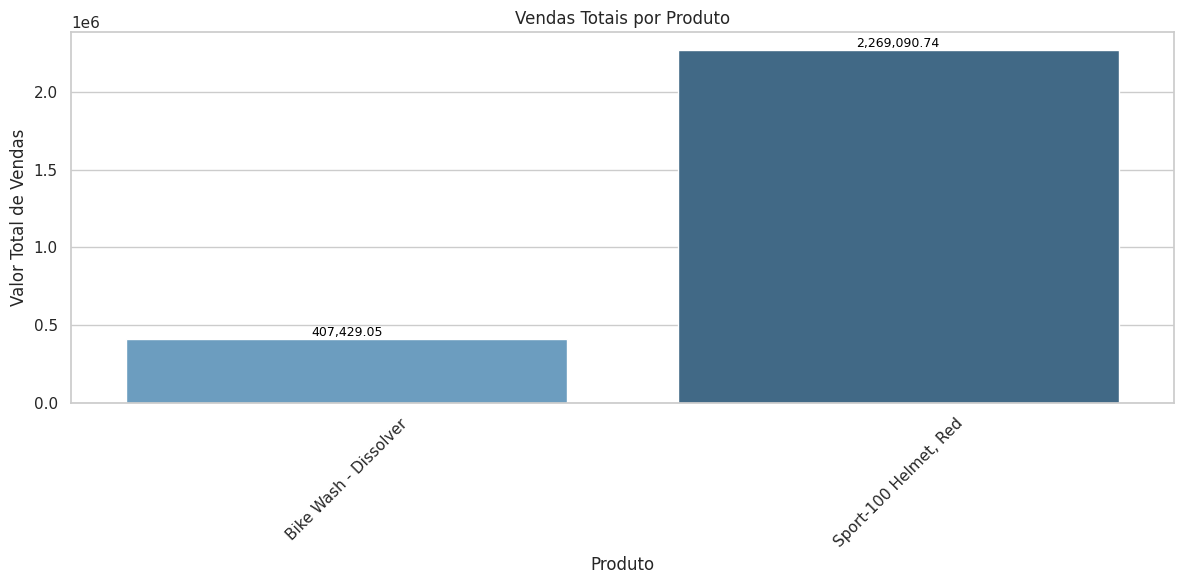

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

#preparando dados (vamos reutilizar o dataset da etapa anterior)
dataset_filtrado_vendas_por_produto = dataset_filtrado.groupby('DS_PRODUTO')['NO_VALOR_TOTAL'].sum().reset_index()

# Estilo do gráfico
sns.set(style="whitegrid")

# Criando o gráfico
plt.figure(figsize=(12,6))
grafico = sns.barplot(
    data=dataset_filtrado_vendas_por_produto,
    x='DS_PRODUTO',
    y='NO_VALOR_TOTAL',
    palette='Blues_d'
)

# Adicionando os valores no topo de cada barra
for index, row in dataset_filtrado_vendas_por_produto.iterrows():
    grafico.text(
        index,
        row['NO_VALOR_TOTAL'],
        f"{row['NO_VALOR_TOTAL']:,.2f}",  # Formata com duas casas decimais
        color='black',
        ha="center",
        va="bottom",
        fontsize=9
    )

# Ajustes visuais
plt.xticks(rotation=45)
plt.xlabel("Produto")
plt.ylabel("Valor Total de Vendas")
plt.title("Vendas Totais por Produto")
plt.tight_layout()
plt.show()


###Um Gráfico de linhas mostrando as vendas ao longo do tempo. (Plotly)

In [6]:
import plotly.express as px
import plotly.io as pio

# Define o renderer do Colab
pio.renderers.default = 'colab'

# Agrupando os dados
vendas_por_data = dataset_filtrado.groupby('DT_PEDIDO')['NO_VALOR_TOTAL'].sum().reset_index()

# Criando o gráfico
fig = px.line(
    vendas_por_data,
    x='DT_PEDIDO',
    y='NO_VALOR_TOTAL',
    markers=True,
    labels={'DT_PEDIDO': 'Data do Pedido', 'NO_VALOR_TOTAL': 'Valor Total de Vendas'}
)

# Centralizando o título
fig.update_layout(
    title={
        'text': 'Vendas ao Longo do Tempo',
        'x': 0.5,
        'xanchor': 'center'
    }
)

# Exibindo
fig.show()
